# **Data Analysis with Linear Regression and Machine Learning**

## **Data Cleaning & Exploration (EDA)**

### **1. Data Overview**

This dataset is a combination of three dataset platforms:

- **Bloomberg** is a global financial services company. It offers green bond identifiers.
- **Factset** is a financial data and software company. It
supplements the dataset with additional information on
company type (private or public) and leverage.
- **SDC (Securities Data Company) Platinum** is a database
providing detailed information on new securities issues.
Here I collect bond-level variables such as yield at
issuance, amount at issuance (in millions), issuance date,
assets before offering (in billions), Return on Assets
(ROA), Moody’s Rating, and Fitch Rating.

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.tools.tools as sm_tools
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Specify the columns you want to import
#columns_to_import = ['greenid', 'index_country', 'sic2', 'annc_date', 'ln_at_billion', 'public', 'leverage', 'ROA','ln_amt_m', 'rating_21', 'yield_issue']
col_to_import = ['Issuer', 'ISIN', 'currency', 'Moody__Rating', 'moody_21', 'country','issuer_group', 'annc_date',
                     'issue_dt', 'mat_dt', 'amt', 'yield_issue', 'coupon', 'green_flag', 'ROA', 'at', 'db_af_offer','at_bf_offer', 'Status',  'sic']
# Read the xlsx file
data = pd.read_excel('base_bond_world_13_21_oct.xlsx', usecols=col_to_import)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78830 entries, 0 to 78829
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Issuer         78830 non-null  object        
 1   ISIN           78830 non-null  object        
 2   currency       78830 non-null  object        
 3   Moody__Rating  78813 non-null  object        
 4   country        78830 non-null  object        
 5   issuer_group   78830 non-null  object        
 6   annc_date      78830 non-null  datetime64[ns]
 7   issue_dt       78830 non-null  int64         
 8   mat_dt         78508 non-null  float64       
 9   amt            78830 non-null  float64       
 10  yield_issue    78830 non-null  float64       
 11  coupon         78498 non-null  float64       
 12  green_flag     1879 non-null   float64       
 13  ROA            39752 non-null  float64       
 14  at             41682 non-null  float64       
 15  db_af_offer    4139

In [4]:
print(data.head(10).to_string())

                       Issuer          ISIN currency Moody__Rating country issuer_group  annc_date  issue_dt   mat_dt     amt  yield_issue  coupon  green_flag  ROA  at  db_af_offer Status  at_bf_offer  moody_21     sic
0                   Actual SA  ARACAL560056      ARP            NR      AR    Corporate 2018-04-10     21287  21652.0   0.497        28.00   28.00         NaN  NaN NaN          NaN  Priv.          NaN       NaN  6141.0
1                   Actual SA  ARACAL560064      ARP            NR      AR    Corporate 2018-10-03     21462  21827.0   0.318        35.00   35.00         NaN  NaN NaN          NaN  Priv.          NaN       NaN  6141.0
2        Agroempresa Colon SA  ARACSA560018       US            NR      AR    Corporate 2017-07-12     21018  21748.0   4.000         6.90    6.90         NaN  NaN NaN          NaN  Priv.          NaN       NaN   139.0
3        Agroempresa Colon SA  ARACSA560042       US            NR      AR    Corporate 2018-01-04     21196  22292.0   0.40

- This panel dataset contains approximately 80,000 rows and 20 variables, providing both company-level and bond-level information. It is particularly relevant for analyzing the factors that influence bond pricing at issuance. The dataset includes key identifiers such as issuer (the issuing entity), cusip9, and ISIN (identifiers issued to securities) and green_flag (indicating whether a bond is self-identified as a green bond).

- Understanding these factors is crucial for investors, policymakers, and financial analysts, as it helps assess how different characteristics—such as company financials, bond type, and sustainability classification—affect bond pricing and market perception.

- Before drawing conclusions, data cleaning and validation are necessary to ensure accuracy and reliability in the analysis.

### **2. Data Selection: Corporate and Public Firms**

In [5]:
# Check whether all the bonds are corporate bonds.
data['issuer_group'].value_counts()

,count
issuer_group,
Corporate,59998
Agency,18403
Securitized/Collateralized,260
Local Authority/Political Division,72
@NA,58
Supranational,28
Sovereign,11


In [6]:
# Only keep corporate bonds
data = data[data['issuer_group'] == 'Corporate']

In [7]:
# Check the status of a company
data['Status'].value_counts()

,count
Status,
Public,25997
Sub.,20821
Priv.,12913
J.V.,261
Mutual,6


In [8]:
# Only keep public companies
data = data[data['Status'] == 'Public']

In a business context,
- "Sub" typically refers to a company that is wholly owned and controlled by another larger company.
- "J.V." is the abbreviation of "Joint Venture," which signifies a business arrangement where two or more separate companies.

Since subsidiary companies and joint adventures could overlap with both private and public companies, to avoid misleading analysis, I only keep public companies for this project.


In [9]:
# Create a variable called 'leverage'
data['leverage'] = 100 * data['db_af_offer'] / data['at_bf_offer']

# Drop the original 2 variables
data.drop(columns=['db_af_offer', 'at_bf_offer'], inplace=True)

In [10]:
# Drop duplicates
data = data.drop_duplicates()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25997 entries, 18 to 78829
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Issuer         25997 non-null  object        
 1   ISIN           25997 non-null  object        
 2   currency       25997 non-null  object        
 3   Moody__Rating  25986 non-null  object        
 4   country        25997 non-null  object        
 5   issuer_group   25997 non-null  object        
 6   annc_date      25997 non-null  datetime64[ns]
 7   issue_dt       25997 non-null  int64         
 8   mat_dt         25808 non-null  float64       
 9   amt            25997 non-null  float64       
 10  yield_issue    25997 non-null  float64       
 11  coupon         25850 non-null  float64       
 12  green_flag     761 non-null    float64       
 13  ROA            20609 non-null  float64       
 14  at             21679 non-null  float64       
 15  Status         25997 no

In [12]:
# Check if there's duplicate in bond-level identifier (ISIN)
data['ISIN'].duplicated().sum()

0

In [13]:
# Summarize the nulls of all columns
data.isnull().sum()

,0
Issuer,0
ISIN,0
currency,0
Moody__Rating,11
country,0
issuer_group,0
annc_date,0
issue_dt,0
mat_dt,189
amt,0


- `mat_dt` is bond maturity date.
- `sic` is the industry code
- `coupon` is the interest paid to a bondholder.

Since the missing values of those three variables don't account a large portion of the total dataset, I will drop the nulls.

- Overall, nearly 50% of ROA and asset values are missing. More specifically, 20% of the values for public firms are missing, while the majority of values for private firms are missing. This is not surprising for private firms due to their lack of publicly available accounting information. Therefore, in this project, I plan to **focus on public companies**.

- For public companies, before deciding whether to drop missing data, I need to conduct further checks because there could be a trade-off between retaining incomplete data and removing potentially useful observations.

In [14]:
# Drop nulls of column 'mat_dt', 'sic', and 'coupon'
data = data.dropna(subset=['mat_dt', 'sic', 'coupon'])

Though it will be ideal to get S&P ratings, due to limited access to SDC,
I collect the Moody’s ratings. I construct the credit rating
variable using the linear transformation of scale 21 (Afonso, Gomes, Rother,
2007). I also construct two dummy variables standing the risk grade of bonds:
investment grade (above or equal to 12 under Scale 21) and speculative grade
(below 12 under Scale 21).

In [15]:
# Check the bond grade provided by Moody's
data['Moody__Rating'].value_counts()[:5]

,count
Moody__Rating,
NR,12366
Baa1,1847
Baa2,1798
A3,1554
Baa3,1291


In [16]:
# Create the dummy variale for risk grade
data['investment_grade'] = data['moody_21'].apply(lambda x: 1 if x >= 12 else 0)

<ipython-input-16-d2e8b4fb8876>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['investment_grade'] = data['moody_21'].apply(lambda x: 1 if x >= 12 else 0)


In [17]:
# Drop null in rating variables
data = data.dropna(subset=['Moody__Rating'])

For the variables of bond ratings:

- ‘NR’ refers to ‘Not Rated.’ The results above show that for both private and public firms, most bonds lack a rating from agencies like Moody’s and Fitch. This is expected because credit ratings are typically sought by larger, publicly traded companies that issue debt in public markets. In contrast, smaller private companies or those with minimal debt needs often do not pursue ratings, as the process can be costly and time-consuming.

- Since more than 70% of bonds in the dataset are unrated, dropping missing values would not be a wise approach. Additionally, including the rating variable in regression and machine learning models for the entire dataset could introduce bias.

- Therefore, I will exclude the rating variable from the main dataset analysis but may incorporate it in a subset analysis where appropriate.

### **3. Handling Outliers and Missing Values**

In [18]:
dt = data.copy()

**First, check if I need to handle outliers by industry.**

In [19]:
# Define SIC code ranges and their corresponding sectors
sic_mapping = {
    '01': 'Agriculture, Forestry, Fishing',
    '02': 'Agriculture, Forestry, Fishing',
    '07': 'Agriculture, Forestry, Fishing',

    '10': 'Mining',
    '12': 'Mining',
    '13': 'Oil & Gas Extraction',

    '15': 'Construction',
    '16': 'Construction',
    '17': 'Construction',

    '20': 'Manufacturing',
    '21': 'Manufacturing',
    '22': 'Manufacturing',
    '23': 'Manufacturing',
    '24': 'Manufacturing',
    '25': 'Manufacturing',
    '26': 'Manufacturing',
    '27': 'Manufacturing',
    '28': 'Manufacturing',
    '29': 'Manufacturing',

    '30': 'Manufacturing',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '34': 'Manufacturing',
    '35': 'Manufacturing',
    '36': 'Manufacturing',
    '37': 'Manufacturing',
    '38': 'Manufacturing',
    '39': 'Manufacturing',

    '40': 'Transportation & Utilities',
    '41': 'Transportation & Utilities',
    '42': 'Transportation & Utilities',
    '43': 'Transportation & Utilities',
    '44': 'Transportation & Utilities',
    '45': 'Transportation & Utilities',
    '46': 'Transportation & Utilities',
    '47': 'Transportation & Utilities',
    '48': 'Transportation & Utilities',
    '49': 'Transportation & Utilities',

    '50': 'Wholesale Trade',
    '51': 'Wholesale Trade',

    '52': 'Retail Trade',
    '53': 'Retail Trade',
    '54': 'Retail Trade',
    '55': 'Retail Trade',
    '56': 'Retail Trade',
    '57': 'Retail Trade',
    '58': 'Retail Trade',
    '59': 'Retail Trade',

    '60': 'Finance, Insurance, Real Estate',
    '61': 'Finance, Insurance, Real Estate',
    '62': 'Finance, Insurance, Real Estate',
    '63': 'Finance, Insurance, Real Estate',
    '64': 'Finance, Insurance, Real Estate',

    '65': 'Real Estate',
    '67': 'Investment & Holding Companies',

    '70': 'Services',
    '72': 'Services',
    '73': 'Services',
    '75': 'Services',
    '76': 'Services',
    '78': 'Services',
    '79': 'Services',
    '80': 'Health Services',
    '81': 'Legal Services',
    '82': 'Educational Services',
    '83': 'Social Services',
    '84': 'Museums, Art, Historical',
    '86': 'Membership Organizations',
    '87': 'Engineering, Management, Research',
    '88': 'Private Households',
    '89': 'Miscellaneous Services',

    '91': 'Public Administration',
    '92': 'Public Administration',
    '93': 'Public Administration',
    '94': 'Public Administration',
    '95': 'Public Administration',
    '96': 'Public Administration',
    '97': 'National Security',
    '99': 'Non-Classifiable'
}


In [20]:
# Ensure SIC codes are treated as strings
dt['sic_str'] = dt['sic'].astype(str)

# Extract first two digits of SIC code to determine the broader sector
dt['sic_prefix'] = dt['sic_str'].str[:2]  # Take the first 2 digits

# Map SIC prefix to sector using the dictionary
dt['industry_sector'] = dt['sic_prefix'].map(sic_mapping).fillna('Other')

# Drop intermediate column
dt.drop(columns=['sic_prefix'], inplace=True)

**Detect outliers within each industry separately**

Text(0, 0.5, 'ROA')

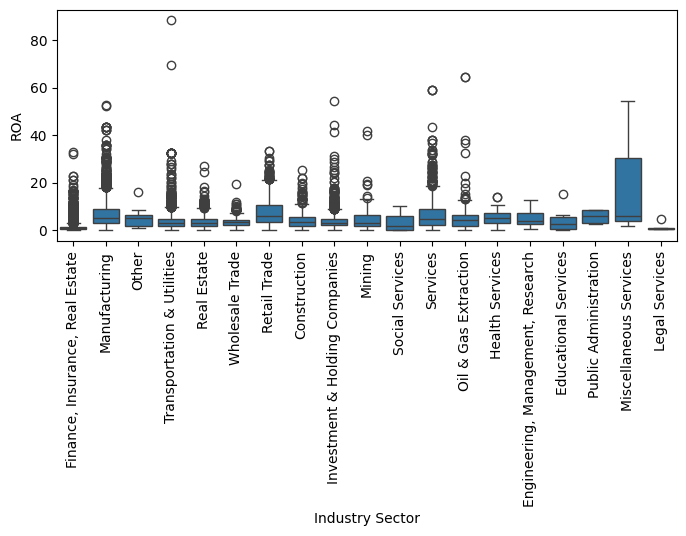

In [21]:
# Create boxplot for ROA column
plt.figure(figsize=(8, 3))
sns.boxplot(x='industry_sector', y='ROA', data=dt)
plt.xticks(rotation=90)
plt.xlabel('Industry Sector')
plt.ylabel('ROA')

Text(0, 0.5, 'Asset')

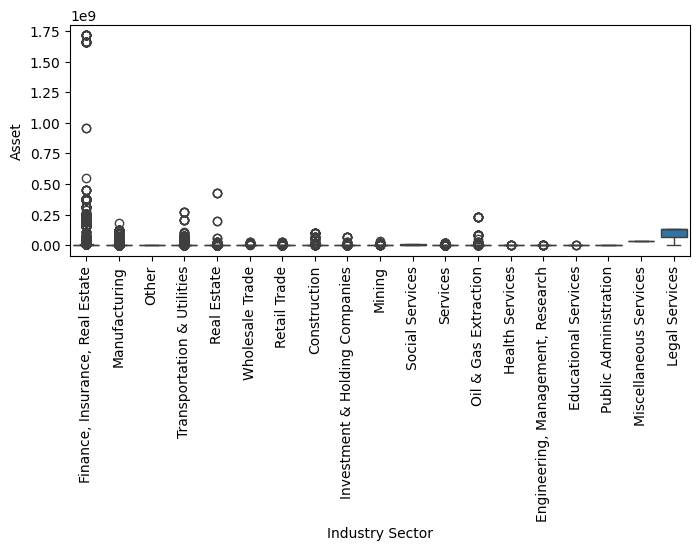

In [22]:
# Create boxplot for Asset column
plt.figure(figsize=(8, 3))
sns.boxplot(x='industry_sector', y='at', data=dt)
plt.xticks(rotation=90)
plt.xlabel('Industry Sector')
plt.ylabel('Asset')

Text(0, 0.5, 'leverage')

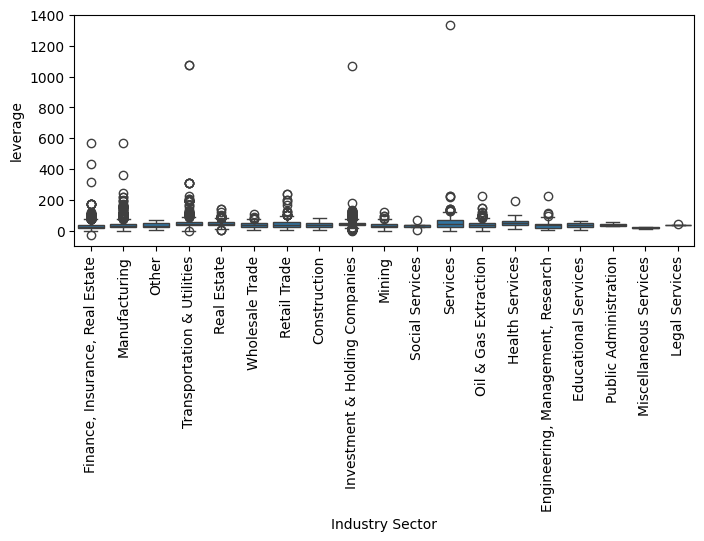

In [23]:
# Create boxplot for leverage column
plt.figure(figsize=(8, 3))
sns.boxplot(x='industry_sector', y='leverage', data=dt)
plt.xticks(rotation=90)
plt.xlabel('Industry Sector')
plt.ylabel('leverage')

- The boxplots by industry show a large variation in data range and variance across industry sectors. Therefore, it is more reasonable to **handle missing values and imputations separately by industry**.

In [24]:
col_to_check = ['ROA', 'at', 'leverage']

# Show missing percentage of three variables by industry sector
missing_by_sector = dt.groupby('industry_sector')[col_to_check].apply(lambda x: x.isnull().mean() * 100)
print(missing_by_sector.sort_values(by='ROA', ascending=False))

                                         ROA         at   leverage
industry_sector                                                   
Mining                             44.827586   6.034483   9.051724
Oil & Gas Extraction               44.233807  15.955766   8.530806
Miscellaneous Services             40.000000  80.000000  40.000000
Social Services                    39.130435  26.086957  34.782609
Health Services                    38.461538  23.846154  15.384615
Other                              29.787234  25.531915  23.404255
Engineering, Management, Research  29.452055  24.657534  25.342466
Educational Services               28.571429   7.142857  14.285714
Investment & Holding Companies     26.424501  22.435897  20.584046
Transportation & Utilities         24.713805  13.108866  12.368126
Services                           24.266145  15.198956  11.545988
Manufacturing                      20.440616  16.233228  11.810502
Construction                       19.774920  16.237942  12.05

The results show the percentage of missing values in ROA for each industry sector, along with the total data available per industry:

- Missing values for ROA and assets are not randomly distributed across industries.

- Mining, Oil & Gas Extraction, Miscellaneous Services, Social Services, and Health Services have over 35-45% missing ROA values, which is quite high.

- Some sectors have moderate missing values, meaning industry-level median imputation could be a viable approach to preserve more data.

- However, industries with a high percentage of missing values do not represent the majority of the public company dataset. Therefore, dropping these industries alone will not fully resolve the issue. Additional steps are needed.



In [25]:
# Drop columns for industries with high missing values
dt = dt[~dt['industry_sector'].isin(['Mining', 'Oil & Gas Extraction', 'Miscellaneous Services', 'Social Services', 'Health Services'])]

**Second, for industries with less portion of missing values, I will use imputations.**

In [26]:
# 1️Keep Original Variables
dt['ROA_orig'] = dt['ROA']
dt['at_orig'] = dt['at']
dt['leverage_orig'] = dt['leverage']

# Handle Outliers by Industry (Capping at 1.5*IQR)
def cap_outliers_by_group(dt, column, group_col):
    """Cap outliers at 1.5*IQR within each industry sector"""
    dt = dt.copy()

    def cap_outliers(group):
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return np.clip(group[column], lower_bound, upper_bound)

    dt[column] = dt.groupby(group_col, group_keys=False).apply(cap_outliers)
    return dt

# Apply outlier treatment to each variable by industry
for var in ['ROA', 'at', 'leverage']:
    dt = cap_outliers_by_group(dt, column=var, group_col='industry_sector')

# Create New Variables for Imputation (Preserve Original Values)
dt['ROA_impute'] = dt['ROA']
dt['at_impute'] = dt['at']
dt['leverage_impute'] = dt['leverage']

# Add Missingness Indicators (1 if missing, 0 if not)
for var in ['ROA', 'at', 'leverage']:
    dt[f'{var}_missing'] = dt[var].isnull().astype(int)

# Apply Median Imputation by Industry Sector
for var in ['ROA_impute', 'at_impute', 'leverage_impute']:
    dt[var] = dt.groupby('industry_sector')[var].transform(lambda x: x.fillna(x.median()))

# Display the final dataframe
dt.head()

<ipython-input-26-e4262a647683>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['ROA_orig'] = dt['ROA']
<ipython-input-26-e4262a647683>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['at_orig'] = dt['at']
<ipython-input-26-e4262a647683>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,Issuer,ISIN,currency,Moody__Rating,country,issuer_group,annc_date,issue_dt,mat_dt,amt,...,industry_sector,ROA_orig,at_orig,leverage_orig,ROA_impute,at_impute,leverage_impute,ROA_missing,at_missing,leverage_missing
18,Banco Hipotecario SA,ARBHIP5600P1,ARP,NR,AR,Corporate,2017-05-02,20947,22043.0,3.574,...,"Finance, Insurance, Real Estate",1.43,348684.5,0.698133,1.43,348684.5,0.698133,0,0,0
19,Banco Hipotecario SA,ARBHIP5600T3,US,NR,AR,Corporate,2017-08-04,21040,21770.0,7.233,...,"Finance, Insurance, Real Estate",2.17,348684.5,0.916521,2.17,348684.5,0.916521,0,0,0
25,Celulosa Argentina SA,ARCELU560066,US,NR,AR,Corporate,2016-11-24,20793,21888.0,40.001,...,Manufacturing,NaN,30709.5,42.201550,5.25,30709.5,42.201550,1,0,0
26,Celulosa Argentina SA,ARCELU5600A2,US,NR,AR,Corporate,2019-05-27,21704,21882.0,3.521,...,Manufacturing,NaN,30709.5,44.572954,5.25,30709.5,44.572954,1,0,0
36,Cresud SA Comercial,ARCRES050298,US,NR,AR,Corporate,2014-09-03,19978,21804.0,33.706,...,Other,NaN,338679.0,51.535613,5.05,338679.0,51.535613,1,0,0


In [27]:
dt.describe()

,annc_date,issue_dt,mat_dt,amt,yield_issue,coupon,green_flag,ROA,at,moody_21,...,investment_grade,ROA_orig,at_orig,leverage_orig,ROA_impute,at_impute,leverage_impute,ROA_missing,at_missing,leverage_missing
count,24600,24600.000000,24600.000000,24600.000000,24600.000000,24600.000000,736.0,19777.000000,2.054700e+04,12611.000000,...,24600.000000,19777.000000,2.054700e+04,21440.000000,24600.000000,2.460000e+04,24600.000000,24600.000000,24600.000000,24600.000000
mean,2017-10-22 21:52:48,21121.171504,24217.223049,465.447874,3.252839,3.221079,1.0,3.846357,1.230504e+06,13.995718,...,0.421707,4.130793,9.373231e+06,40.420838,3.750410,1.099662e+06,38.917201,0.196057,0.164756,0.128455
min,2013-01-02 00:00:00,19362.000000,19764.000000,0.014000,0.001000,0.001000,1.0,0.000000,7.000000e-01,3.000000,...,0.000000,0.000000,7.000000e-01,-27.977354,0.000000,7.000000e-01,-21.492384,0.000000,0.000000,0.000000
25%,2015-09-09 00:00:00,20346.000000,22525.000000,90.110000,1.000000,0.999750,1.0,1.020000,3.298200e+04,12.000000,...,0.000000,1.020000,3.298200e+04,23.664384,1.040000,4.313750e+04,24.063582,0.000000,0.000000,0.000000
50%,2017-12-01 00:00:00,21164.000000,23634.000000,297.585000,2.862500,2.839500,1.0,2.670000,2.343320e+05,14.000000,...,0.000000,2.670000,2.349507e+05,37.320106,2.940000,2.362883e+05,36.868485,0.000000,0.000000,0.000000
75%,2020-01-24 00:00:00,21945.000000,24923.000000,625.000000,4.625000,4.600000,1.0,5.180000,1.212087e+06,16.000000,...,1.000000,5.480000,1.463988e+06,52.100030,5.250000,1.000244e+06,49.572181,0.000000,0.000000,0.000000
max,2021-12-30 00:00:00,22645.000000,59036.000000,15000.000000,60.000000,60.000000,1.0,21.105000,1.316436e+08,21.000000,...,1.000000,88.310000,1.715256e+09,1333.333333,21.105000,1.316436e+08,128.903527,1.000000,1.000000,1.000000
std,NaN,931.720595,2833.725788,576.322815,2.654750,2.644284,0.0,3.887887,2.947930e+06,3.476986,...,0.493842,4.716144,7.654094e+07,28.116815,3.566161,2.715819e+06,19.028137,0.397020,0.370968,0.334603


In [28]:
# Drop observations where leverage is negative
dt = dt[dt['leverage_impute'] >= 0]

**Third, check the distribution of important variables**

Text(0.5, 1.0, 'Histogram of Asset')

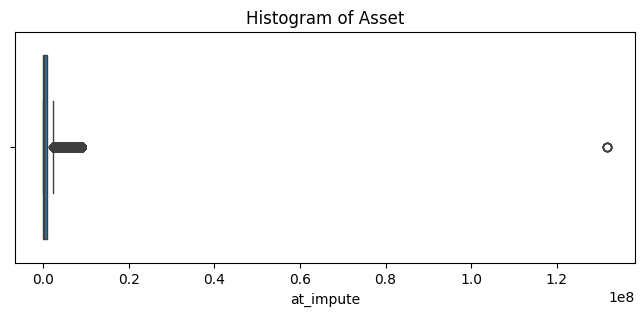

In [29]:
# Boxplot for Asset to check the whole distribution
plt.figure(figsize=(8,3))
sns.boxplot(data=dt, x='at_impute')
plt.title('Histogram of Asset')

There appears to be an extremely large data point.

In [30]:
# Sort the at_impute descending
dt.sort_values(by='at_impute', ascending=False).head(10)['at_impute']

,at_impute
17490,1.316436e+08
17549,1.316436e+08
17550,1.316436e+08
17491,1.316436e+08
17551,1.316436e+08
17824,8.774820e+06
62396,8.774820e+06
68796,8.774820e+06
24192,8.774820e+06
68776,8.774820e+06


The first several rows has an extremely large asset amount, therefore, I drop those outliers.

In [31]:
# Drop the largest asset amount which equals to 131643632.5
dt = dt[dt['at_impute'] < 131643632.5]

Text(0.5, 1.0, 'Histogram of amount at issuance')

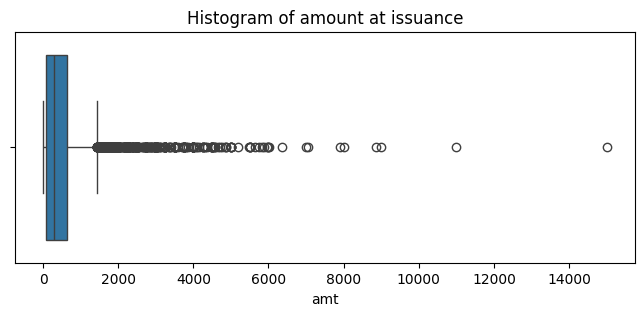

In [32]:
# Boxplot for amount at issuance (amt)
plt.figure(figsize=(8,3))
sns.boxplot(data=dt, x='amt')
plt.title('Histogram of amount at issuance')

In [33]:
# Create variable 'duration'

# Check data types of matrity date and issue date and change them to datetime format
dt['issue_dt1'] = pd.to_datetime(dt['issue_dt'], origin='1960-01-01', unit='D')
dt['mat_dt1'] = pd.to_datetime(dt['mat_dt'], origin='1960-01-01', unit='D')

# Extrac issue year from issue_dt1
dt['issue_year'] = dt['issue_dt1'].dt.year

# Create duration with the unit year
dt['duration'] = (dt['mat_dt1'] - dt['issue_dt1']).dt.days / 365

dt.head()

,Issuer,ISIN,currency,Moody__Rating,country,issuer_group,annc_date,issue_dt,mat_dt,amt,...,ROA_impute,at_impute,leverage_impute,ROA_missing,at_missing,leverage_missing,issue_dt1,mat_dt1,issue_year,duration
18,Banco Hipotecario SA,ARBHIP5600P1,ARP,NR,AR,Corporate,2017-05-02,20947,22043.0,3.574,...,1.43,348684.5,0.698133,0,0,0,2017-05-08,2020-05-08,2017,3.002740
19,Banco Hipotecario SA,ARBHIP5600T3,US,NR,AR,Corporate,2017-08-04,21040,21770.0,7.233,...,2.17,348684.5,0.916521,0,0,0,2017-08-09,2019-08-09,2017,2.000000
25,Celulosa Argentina SA,ARCELU560066,US,NR,AR,Corporate,2016-11-24,20793,21888.0,40.001,...,5.25,30709.5,42.201550,1,0,0,2016-12-05,2019-12-05,2016,3.000000
26,Celulosa Argentina SA,ARCELU5600A2,US,NR,AR,Corporate,2019-05-27,21704,21882.0,3.521,...,5.25,30709.5,44.572954,1,0,0,2019-06-04,2019-11-29,2019,0.487671
36,Cresud SA Comercial,ARCRES050298,US,NR,AR,Corporate,2014-09-03,19978,21804.0,33.706,...,5.05,338679.0,51.535613,1,0,0,2014-09-12,2019-09-12,2014,5.002740


Text(0.5, 1.0, 'Histogram of duration')

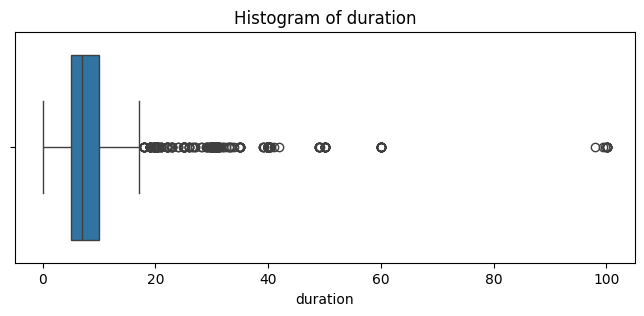

In [34]:
# Plot duration
plt.figure(figsize=(8,3))
sns.boxplot(data=dt, x='duration')
plt.title('Histogram of duration')

In [35]:
# Sort duration in descending order
dt.sort_values(by='duration', ascending=False).head(10)['duration']

,duration
34950,100.076712
59447,100.073973
13681,100.065753
27479,100.065753
27501,100.065753
24967,100.065753
64750,100.065753
27492,100.063014
24973,99.865753
25058,99.443836


In [36]:
# Check industry sectors for bonds with duration more than 50 years.
dt[dt['duration'] > 50]['industry_sector'].value_counts()

,count
industry_sector,
Transportation & Utilities,41
Manufacturing,6
Real Estate,4
Construction,2
Investment & Holding Companies,1
Services,1


- Observing that the duration variable also contains some very large values, I initially found durations over 50 years to be quite long. However, after verifying the information for these long-duration bonds, I confirmed that they do exist and that the data is correct.
- Further exploration reveals that most of these bonds come from industries requiring long-term capital investments, such as infrastructure, utilities, energy. Companies in these sectors may issue ultra-long bonds to align their financing with the long lifespans of their assets.
- Therefore, I will **retain these large values without imputation**.

Text(0.5, 1.0, 'Histogram of yield_issue')

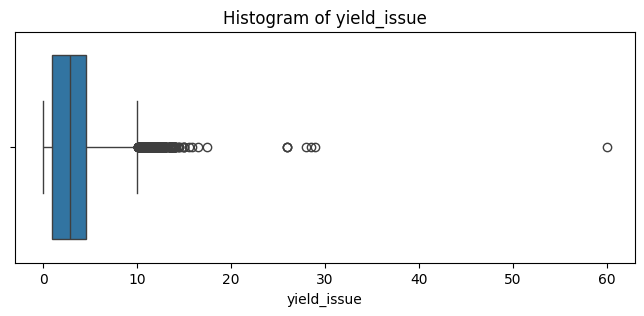

In [37]:
# Check distribution of yield_issue
plt.figure(figsize=(8,3))
sns.boxplot(data=dt, x='yield_issue')
plt.title('Histogram of yield_issue')

In [38]:
 # Sort yield at issuance in descending order to check the highest values
 print(dt.sort_values(by='yield_issue', ascending=False).head(10).to_string())

                              Issuer          ISIN currency Moody__Rating country issuer_group  annc_date  issue_dt   mat_dt      amt  yield_issue  coupon  green_flag    ROA          at  Status  moody_21     sic   leverage  investment_grade sic_str                  industry_sector  ROA_orig    at_orig  leverage_orig  ROA_impute   at_impute  leverage_impute  ROA_missing  at_missing  leverage_missing  issue_dt1    mat_dt1  issue_year  duration
54            Angel Estrada Y Cia SA  ARESTR590096      ARP            NR      AR    Corporate 2018-12-11     21535  21715.0    1.690       60.000  60.000         NaN    NaN     3574.20  Public       NaN  2621.0  43.653251                 0  2621.0                    Manufacturing       NaN     3574.2      43.653251       5.250     3574.20        43.653251            1           0                 0 2018-12-17 2019-06-15        2018  0.493151
136                          TGLT SA  ARTGLT560019      ARP            NR      AR    Corporate 2015-05-05   

In [39]:
# Count bonds numbers by industry where yield issue > 10
dt[dt['yield_issue'] > 10]['country'].value_counts()[:5]

,count
country,
CH,99
ID,70
IN,43
HK,37
US,33


In [40]:
# Count bonds numbers by year where yield issue > 10
dt[dt['yield_issue'] > 10]['issue_year'].value_counts()[:5]

,count
issue_year,
2019,84
2020,57
2015,48
2014,45
2018,40


- Corporate bond yield over 10% is possible, but a corporate bond yielding over 20% is a major red flag unless there’s a clear reason. Therefore, I drop observations with yield at issuance higher then 15%.

In [41]:
# Drop observations where yield at issurance is higher than 15%.
dt = dt[dt['yield_issue'] < 15]

Text(0.5, 1.0, 'Histogram of amount at issuance')

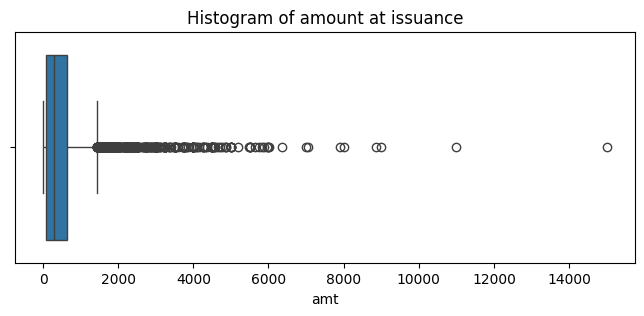

In [42]:
# Check distribution of amount at issuance
plt.figure(figsize=(8,3))
sns.boxplot(data=dt, x='amt')
plt.title('Histogram of amount at issuance')

In [43]:
# Sort amount at issuance at decending order and show the first 10 lines
print(dt.sort_values(by='amt', ascending=False).head(10).to_string())

                               Issuer          ISIN currency Moody__Rating country issuer_group  annc_date  issue_dt   mat_dt        amt  yield_issue  coupon  green_flag   ROA           at  Status  moody_21     sic   leverage  investment_grade sic_str                  industry_sector  ROA_orig     at_orig  leverage_orig  ROA_impute    at_impute  leverage_impute  ROA_missing  at_missing  leverage_missing  issue_dt1    mat_dt1  issue_year   duration
63903      Verizon Communications Inc  US92343VBT08       US          Baa1      US    Corporate 2013-09-11     19619  30573.0  15000.000        6.559   6.550         NaN  0.99   366596.000  Public      14.0  4813.0  44.388527                 1  4813.0       Transportation & Utilities      0.99    366596.0      44.388527        0.99   366596.000        44.388527            0           0                 0 2013-09-18 2043-09-15        2013  30.010959
63901      Verizon Communications Inc  US92343VBR42       US          Baa1      US    Corporate 

In [44]:
# Count by industry for amount at issuance over $2 billion.
dt[dt['amt'] > 2000]['industry_sector'].value_counts()[:5]

,count
industry_sector,
"Finance, Insurance, Real Estate",164
Manufacturing,122
Transportation & Utilities,95
Services,53
Retail Trade,16


- The dataset contains some large issuance amounts, such as \$15 billion from Verizon (ISIN: US92343VBT08) and \$9 billion from CVS (ISIN: US126650CX62). These initially appear to be extreme values; however, a double-check confirms that these figures are accurate.
- Companies in sectors like infrastructure, telecom, energy, and manufacturing require substantial funds for projects such as building factories, power plants, or nationwide networks.
- Financial institutions (e.g., banks and insurance companies) frequently raise large sums of debt for lending, investment, and regulatory capital requirements;
Real estate firms issue bonds to finance large-scale property developments and acquisitions.
- I retain these extreme values since they are valid and reflect real-world financial transactions.

### **4. Descriptive Statistics & Visualizations**

In [45]:
# Drop columes for future analysis
dt.drop(columns=['issuer_group', 'issue_dt', 'mat_dt', 'sic','Status', 'ROA_orig', 'at_orig', 'leverage_orig'], inplace=True)

In [46]:
# Take the log for amount at issuance and asset
dt['amt_log'] = np.log(dt['amt'])
dt['at_log'] = np.log(dt['at_impute'])

In [47]:
# Print out the first several lines
print(dt.head(10).to_string())

                    Issuer          ISIN currency Moody__Rating country  annc_date     amt  yield_issue  coupon  green_flag   ROA        at  moody_21   leverage  investment_grade sic_str                  industry_sector  ROA_impute  at_impute  leverage_impute  ROA_missing  at_missing  leverage_missing  issue_dt1    mat_dt1  issue_year  duration   amt_log     at_log
18    Banco Hipotecario SA  ARBHIP5600P1      ARP            NR      AR 2017-05-02   3.574        2.750    2.75         NaN  1.43  348684.5       NaN   0.698133                 0  6000.0  Finance, Insurance, Real Estate        1.43   348684.5         0.698133            0           0                 0 2017-05-08 2020-05-08        2017  3.002740  1.273685  12.761923
19    Banco Hipotecario SA  ARBHIP5600T3       US            NR      AR 2017-08-04   7.233        4.000    4.00         NaN  2.17  348684.5       NaN   0.916521                 0  6000.0  Finance, Insurance, Real Estate        2.17   348684.5         0.916521     

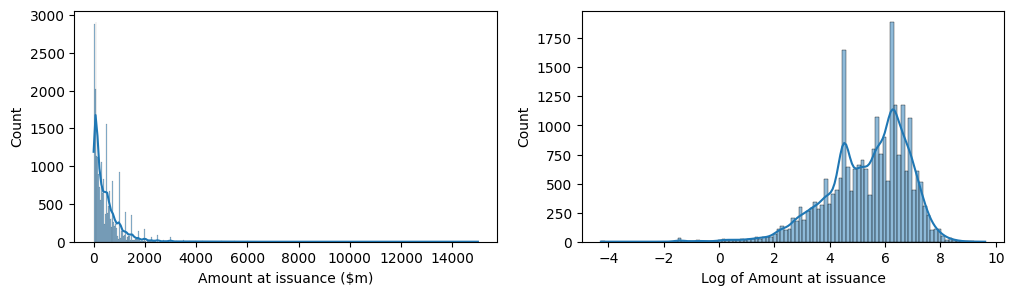

In [48]:
# Plot the histogram for amount at issuance and the log amount of issuance.
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.histplot(data=dt, x='amt', kde=True)
plt.xlabel('Amount at issuance ($m)')

plt.subplot(1,2,2)
sns.histplot(data=dt, x='amt_log', kde=True)
plt.xlabel('Log of Amount at issuance')
plt.tight_layout
plt.show()

- The original amount at issuance variable is highly right-skewed, meaning it has extreme values that could disproportionately affect regression results.
- The log transformation reduces skewness, making the distribution more normal-like, which is a key assumption in linear regression.

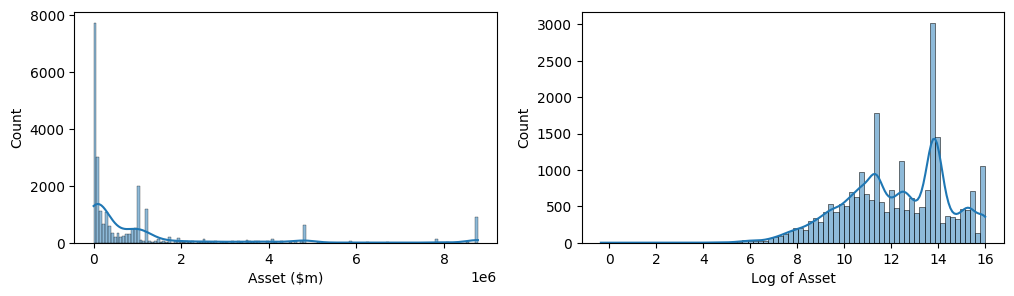

In [49]:
# Plot the histogram for amount at issuance and the log amount of issuance.
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.histplot(data=dt, x='at_impute', kde=True)
# Add axis name
plt.xlabel('Asset ($m)')

plt.subplot(1,2,2)
sns.histplot(data=dt, x='at_log', kde=True)
plt.xlabel('Log of Asset')

plt.tight_layout
plt.show()

- Like the amount at issuance variable, the original asset variable is highly right-skewed, while the log transformation reduces skewness.

In [50]:
# Create a dummy greenid based on green_flag
dt['greenid'] = dt['green_flag'].apply(lambda x: 1 if x == 1 else 0)
dt['greenid'].value_counts()

# Drop green_flag
dt.drop(columns=['green_flag'], inplace=True)

In [51]:
# Cound bond numbers by year and greenid
dt.groupby(['issue_year', 'greenid']).size().unstack()

greenid,0,1
issue_year,,
2013,2167,4
2014,2299,9
2015,2291,30
2016,2683,29
2017,2851,49
2018,2580,67
2019,3004,130
2020,3158,170
2021,2812,247


The trend of green bond issuance mainly started after 2015 Paris Climate Agreement. There were few before that.

In [52]:
# Count bond issurance by industry and greenid
dt.groupby(['industry_sector', 'greenid']).size().unstack()

greenid,0,1
industry_sector,,
Construction,602.0,20.0
Educational Services,14.0,NaN
"Engineering, Management, Research",140.0,6.0
"Finance, Insurance, Real Estate",7355.0,182.0
Investment & Holding Companies,1247.0,156.0
Legal Services,2.0,NaN
Manufacturing,5942.0,91.0
Other,47.0,NaN
Public Administration,2.0,2.0


In [53]:
# Count bond issurance by currency and sort
dt.groupby(['currency']).size().sort_values(ascending=False)[:10]

,0
currency,
US,9392
Y,4065
EUR,3721
CY,1157
RE,1045
BA,918
SFR,613
TW,551
RH,522


In [54]:
# Count bond issurance by country
dt.groupby(['country']).size().sort_values(ascending=False)[:10]

,0
country,
US,7550
JP,4017
CH,1456
IN,1094
FR,1019
TH,913
WG,796
AU,635
CA,623


In [55]:
# Columns for statistical description
col_for_stat =['yield_issue', 'coupon', 'duration', 'moody_21', 'amt', 'at', 'ROA', 'leverage', 'at_impute', 'ROA_impute', 'leverage_impute']

# Display statistical description, and don't written in scientific notation
pd.options.display.float_format = '{:.2f}'.format
dt[col_for_stat].describe()

,yield_issue,coupon,duration,moody_21,amt,at,ROA,leverage,at_impute,ROA_impute,leverage_impute
count,24580.00,24580.00,24580.00,12608.00,24580.00,20528.00,19761.00,21420.00,24580.00,24580.00,24580.00
mean,3.24,3.21,8.49,14.00,465.75,1199245.74,3.85,39.35,1073459.60,3.75,38.93
std,2.59,2.58,7.33,3.48,576.45,2134028.55,3.89,20.04,1978360.03,3.57,19.03
min,0.00,0.00,0.08,3.00,0.01,0.70,0.00,0.03,0.70,0.00,0.03
25%,1.00,0.99,5.00,12.00,90.19,32954.25,1.02,23.67,43137.50,1.04,24.06
50%,2.86,2.82,7.00,14.00,298.36,233876.00,2.67,37.33,235723.00,2.94,36.87
75%,4.62,4.60,10.01,16.00,625.00,1212087.00,5.18,52.11,1000244.30,5.25,49.60
max,14.79,14.50,100.08,21.00,15000.00,8774820.12,21.10,128.90,8774820.12,21.10,128.90


In [56]:
# Display statistical results for common bonds
dt[dt['greenid'] == 0][col_for_stat].describe()

,yield_issue,coupon,duration,moody_21,amt,at,ROA,leverage,at_impute,ROA_impute,leverage_impute
count,23845.00,23845.00,23845.00,12309.00,23845.00,19991.00,19209.00,20828.00,23845.00,23845.00,23845.00
mean,3.27,3.24,8.52,14.00,468.25,1200329.90,3.87,39.37,1077150.46,3.77,38.92
std,2.60,2.59,7.40,3.48,578.90,2134693.07,3.91,20.13,1982210.27,3.59,19.13
min,0.00,0.00,0.08,3.00,0.01,0.70,0.00,0.03,0.70,0.00,0.03
25%,1.00,1.00,5.00,12.00,90.58,32507.35,1.02,23.62,42909.50,1.05,24.06
50%,2.91,2.88,7.00,14.00,300.00,231306.00,2.67,37.27,232999.00,2.94,36.73
75%,4.65,4.62,10.01,16.00,642.70,1212087.00,5.22,52.24,1000244.30,5.25,49.72
max,14.79,14.50,100.08,21.00,15000.00,8774820.12,21.10,128.90,8774820.12,21.10,128.90


- Notice there are 700 green bonds vs. 24,000 common bonds, which can lead to biased results since the model may be overly influenced by common bonds.

- Considering the unbalance, **balanced sample matching** may help ensure that green and common bonds are compared under similar conditions, reducing biases. I will talk about this in the next section while deciding models.

In [57]:
# Display statistical results for green bonds
dt[dt['greenid'] == 1][col_for_stat].describe()

,yield_issue,coupon,duration,moody_21,amt,at,ROA,leverage,at_impute,ROA_impute,leverage_impute
count,735.00,735.00,735.00,299.00,735.00,537.00,552.00,592.00,735.00,735.00,735.00
mean,2.14,2.07,7.32,13.90,384.51,1158885.53,3.00,38.60,953720.00,2.99,39.13
std,2.25,2.17,4.48,3.07,483.57,2110712.43,2.88,16.22,1846367.07,2.55,15.09
min,0.01,0.01,0.49,6.00,2.80,692.10,0.00,3.35,692.10,0.00,3.35
25%,0.51,0.50,5.00,13.00,59.75,80633.00,0.86,26.36,82911.20,1.00,27.12
50%,1.50,1.45,6.12,14.00,200.00,348771.30,2.41,38.74,267129.30,2.91,41.05
75%,3.00,2.99,10.01,16.00,579.28,1000244.30,3.78,48.09,1000244.30,3.43,46.79
max,13.00,13.00,35.02,21.00,4319.79,8774820.12,18.06,91.45,8774820.12,18.06,91.45


<Figure size 1200x1200 with 0 Axes>

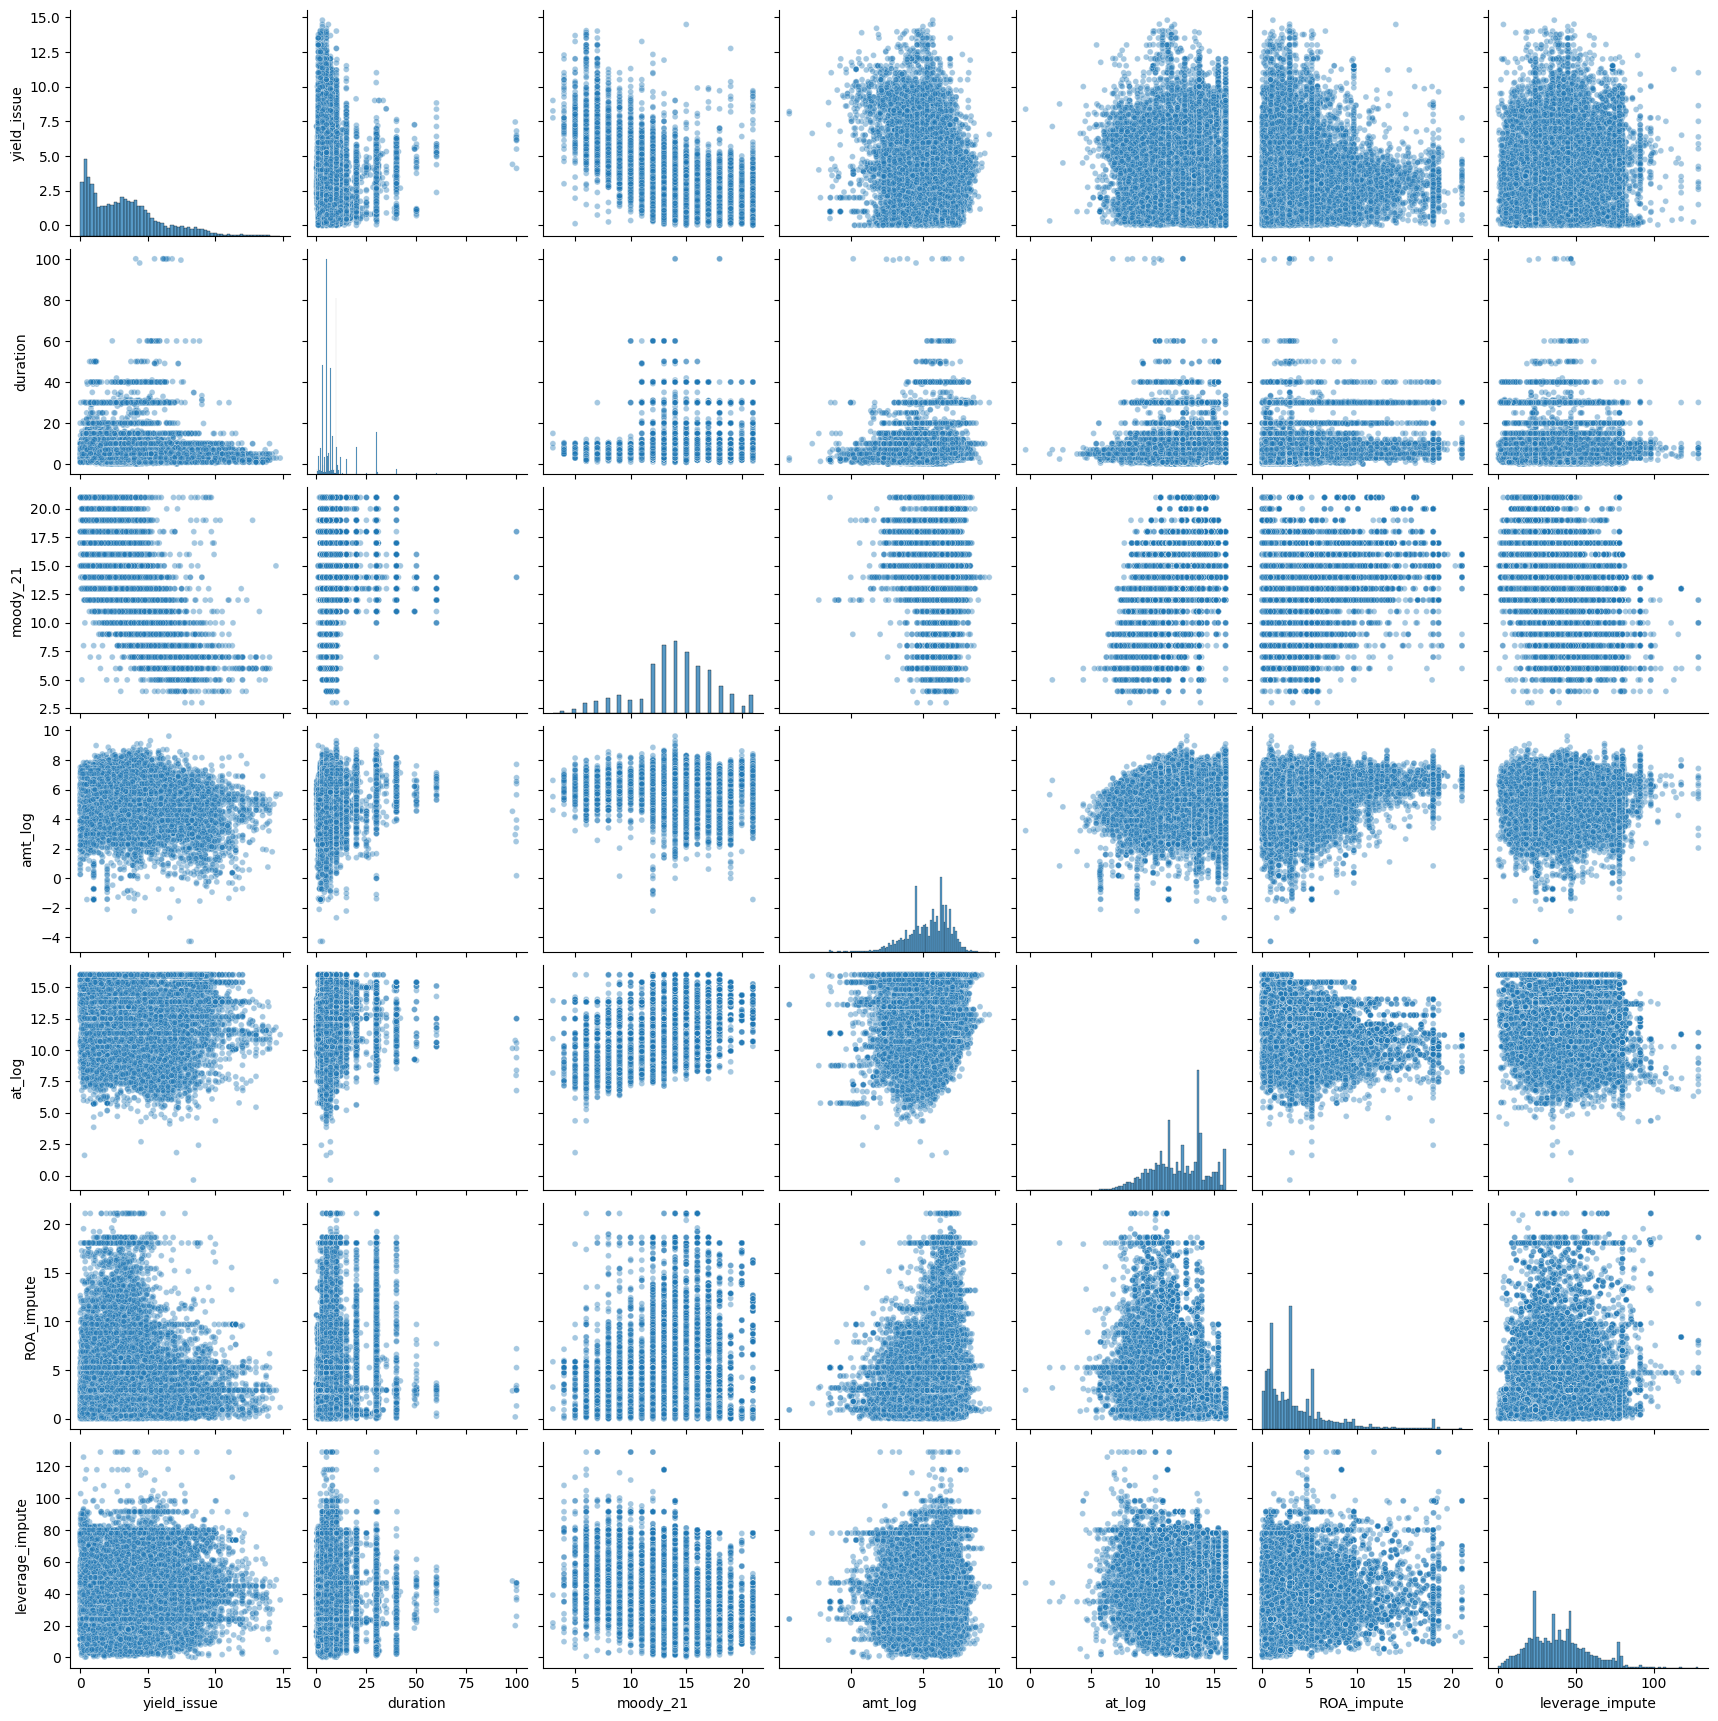

In [58]:
# Create scatterplots among variables
plt.figure(figsize=(12, 12))
# Create a pairplot to visualize pairwise relationships between variables in the data
sns.pairplot(dt[['yield_issue', 'duration', 'moody_21', 'amt_log', 'at_log', 'ROA_impute', 'leverage_impute']],
             plot_kws={'alpha':0.4, 'size':5},
             );

- The scatterplots show no clear linear trend (e.g., no upward or downward patterns), a simple OLS regression might not perform well.
- Next, compute correlation coefficients (Pearson) to quantify relationships.

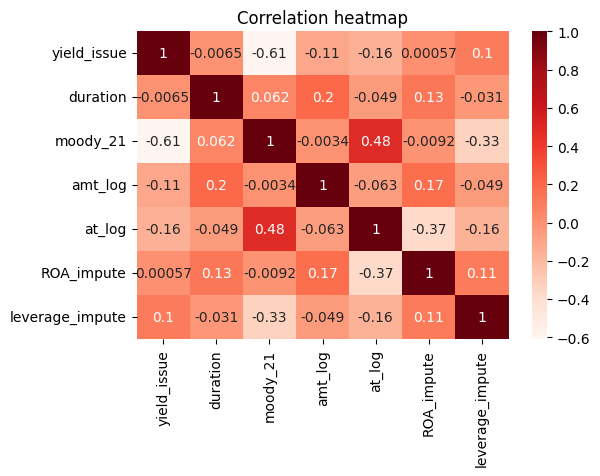

In [59]:
# Create correlation heatmap
df_heatmap = dt[['yield_issue', 'duration', 'moody_21', 'amt_log', 'at_log', 'ROA_impute', 'leverage_impute']]

plt.figure(figsize=(6,4))
sns.heatmap(df_heatmap.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap',
          fontsize=12)
plt.show()

**Key Takeaways So Far:**
- **Weak Linear Relationships**: The scatterplots and correlation heatmap suggest that most independent variables have weak correlations with yield_issue, except for moody_21 (-0.61), indicating that credit rating is the strongest predictor of bond yield.

- **Potential Multicollinearity**: moody_21 and at_log show moderate correlation (0.48), which may lead to multicollinearity issues. Further VIF analysis is needed to confirm if this affects model stability.

- **Challenges for OLS Regression**: Given the lack of strong linear relationships, an OLS model may have low explanatory power.

## **Machine Learning: PSM & kNN**
- One of the primary challenges in comparing green bonds
with regular bonds is the **significant size imbalance between
the two groups**. In my dataset, the number of regular bonds
is substantially larger than the number of green bonds. This
imbalance can introduce bias and affect the reliability of any
comparative analysis.
- To address this issue, I employ **Propensity
Score Matching (PSM)** and **Nearest Neighbor Matching
(NNM)** to create a balanced dataset, ensuring that green bonds
are matched with comparable regular bonds.

### **1. Propensity Score Match**
- I plan to use **Propensity Score Matching (PSM)** to create a matched common bond sample. PSM is a method that estimates the likelihood of a bond being green based on certain characteristics (like credit rating, issuance amount, and financial metrics) and then pairs each green bond with a common bond that has a similar likelihood.

- In other words, it's **like finding a fair comparison partner for each green bond**—similar to making sure you're comparing two athletes with similar training levels before judging their race times. This way, we ensure that differences in bond prices are not just due to factors like company size or credit rating but are actually related to whether the bond is green or not.

- Following PSM, Nearest Neighbor Matching (NNM) further
refines the matching process by selecting the closest regular
bond for each green bond. This approach enhances the comparability
of the matched pairs, ensuring that the bonds are as
similar as possible except for the green label, thereby reducing
bias in the treatment effect estimation.

In [60]:
# Step 1: One-Hot Encode 'country' and 'industry_sector'
data_dummy = pd.get_dummies(dt[['country', 'industry_sector']], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
data_encoded = pd.concat([dt, data_dummy], axis=1)

# Step 2: Define Features for Propensity Score Estimation (Exclude Outcome Variables)
features = ['duration', 'coupon', 'amt_log', 'at_log', 'ROA_impute', 'leverage_impute']  # Main features

# Add encoded categorical variables (one-hot encoded 'country' & 'industry_sector')
features += [col for col in data_encoded.columns if col.startswith(('country_', 'industry_sector_'))]

# Ensure all features are numerical and free of NaN values
X = data_encoded[features]
y = data_encoded['greenid']

# Step 3: Scale the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Estimate Propensity Scores Using Logistic Regression
log_reg = LogisticRegression(max_iter=10000)  # Ensure convergence
log_reg.fit(X_scaled, y)

propensity_scores = log_reg.predict_proba(X_scaled)[:, 1]

# Add propensity scores to the dataset
data_encoded['propensity_score'] = propensity_scores

# Step 5: Perform 1-to-1 Matching Within Each Currency Group
matched_samples = []

for currency in data_encoded['currency'].unique():  # Ensuring bonds are matched within the same currency
    data_currency = data_encoded[data_encoded['currency'] == currency]  # Filter by currency

    # Ensure both green and common bonds exist in the currency group
    if data_currency['greenid'].nunique() < 2:
        print(f"Skipping {currency} due to missing green/common bonds.")
        continue

    # Split into green and common bonds
    green_bonds = data_currency[data_currency['greenid'] == 1]
    common_bonds = data_currency[data_currency['greenid'] == 0]

    # Perform Nearest Neighbor Matching (n=1 for 1-to-1 matching)
    nn = NearestNeighbors(n_neighbors=1, metric='manhattan') # By default
    nn.fit(common_bonds[['propensity_score']])  # Fit common bonds
    distances, indices = nn.kneighbors(green_bonds[['propensity_score']])  # Find closest match

    # Retrieve matched green and common bonds
    matched_common_bonds = common_bonds.iloc[indices.flatten()].reset_index(drop=True)
    matched_green_bonds = green_bonds.reset_index(drop=True)

    matched_data = pd.concat([matched_green_bonds, matched_common_bonds])
    matched_samples.append(matched_data)

# Step 6: Combine Matched Data
if matched_samples:
    matched_df = pd.concat(matched_samples).reset_index(drop=True)
    matched_df.to_csv("matched_bond_dataset_n1.csv", index=False)
    print("Matching complete. Matched dataset saved as 'matched_bond_dataset_n1.csv'.")
else:
    print("No matched samples found. Adjust parameters or check dataset.")

Skipping ARP due to missing green/common bonds.
Skipping LEV due to missing green/common bonds.
Skipping C due to missing green/common bonds.
Skipping CE due to missing green/common bonds.
Skipping UF due to missing green/common bonds.
Skipping CP due to missing green/common bonds.
Skipping DKR due to missing green/common bonds.
Skipping RL due to missing green/common bonds.
Skipping HF due to missing green/common bonds.
Skipping MP due to missing green/common bonds.
Skipping RH due to missing green/common bonds.
Skipping KD due to missing green/common bonds.
Skipping KZT due to missing green/common bonds.
Skipping SLR due to missing green/common bonds.
Skipping RG due to missing green/common bonds.
Skipping PS due to missing green/common bonds.
Skipping PP due to missing green/common bonds.
Skipping PZ due to missing green/common bonds.
Skipping RR due to missing green/common bonds.
Skipping TL due to missing green/common bonds.
Skipping VTD due to missing green/common bonds.
Skipping

In [61]:
# Check by green id
matched_df.groupby(['greenid']).size()

,0
greenid,
0,735
1,735


After the matching, conduct **Welch’s t-test** and displays the mean values for each key feature between green bonds and matched common bonds:

In [62]:
# Define the key features for testing
key_features = ['yield_issue', 'duration', 'coupon', 'amt_log', 'at_log', 'ROA_impute', 'leverage_impute']

# Separate green bonds and matched common bonds
green_bonds0 = dt[dt['greenid'] == 1]
common_bonds0 = dt[dt['greenid'] == 0]

# Perform t-tests and store results along with mean values
t_test_results = []

for feature in key_features:
    t_stat, p_value = ttest_ind(
        green_bonds0[feature], common_bonds0[feature], equal_var=False  # Welch’s t-test for unequal variance
    )
    t_test_results.append({
        'Feature': feature,
        'Green Bond Mean': green_bonds0[feature].mean(),
        'Common Bond Mean': common_bonds0[feature].mean(),
        'T-statistic': t_stat,
        'P-value': p_value
    })

# Convert results into a DataFrame for easy viewing
t_test_unmatched = pd.DataFrame(t_test_results)

# Display the results
print("\n=== T-Test Results:  Green Bonds vs. Unmatched Common Bonds ===\n")
print(t_test_unmatched)



=== T-Test Results:  Green Bonds vs. Unmatched Common Bonds ===

           Feature  Green Bond Mean  Common Bond Mean  T-statistic  P-value
0      yield_issue             2.14              3.27       -13.39     0.00
1         duration             7.32              8.52        -7.01     0.00
2           coupon             2.07              3.24       -14.38     0.00
3          amt_log             5.19              5.39        -3.90     0.00
4           at_log            12.47             12.17         4.32     0.00
5       ROA_impute             2.99              3.77        -8.10     0.00
6  leverage_impute            39.13             38.92         0.36     0.72


In [63]:
# Define the key features for testing
key_features = ['yield_issue', 'duration', 'coupon', 'amt_log', 'at_log', 'ROA_impute', 'leverage_impute']

# Separate green bonds and matched common bonds
green_bonds = matched_df[matched_df['greenid'] == 1]
common_bonds = matched_df[matched_df['greenid'] == 0]

# Perform t-tests and store results along with mean values
t_test_results = []

for feature in key_features:
    t_stat, p_value = ttest_ind(
        green_bonds[feature], common_bonds[feature], equal_var=False  # Welch’s t-test for unequal variance
    )
    t_test_results.append({
        'Feature': feature,
        'Green Bond Mean': green_bonds[feature].mean(),
        'Common Bond Mean': common_bonds[feature].mean(),
        'T-statistic': t_stat,
        'P-value': p_value
    })

# Convert results into a DataFrame for easy viewing
t_test_matched = pd.DataFrame(t_test_results)

# Display the results
print("\n=== T-Test Results:  Green Bonds vs. Matched Common Bonds ===\n")
print(t_test_matched)



=== T-Test Results:  Green Bonds vs. Matched Common Bonds ===

           Feature  Green Bond Mean  Common Bond Mean  T-statistic  P-value
0      yield_issue             2.14              2.19        -0.44     0.66
1         duration             7.32              7.07         1.06     0.29
2           coupon             2.07              2.12        -0.48     0.63
3          amt_log             5.19              5.23        -0.43     0.67
4           at_log            12.47             12.49        -0.30     0.76
5       ROA_impute             2.99              3.15        -1.14     0.25
6  leverage_impute            39.13             39.77        -0.78     0.44


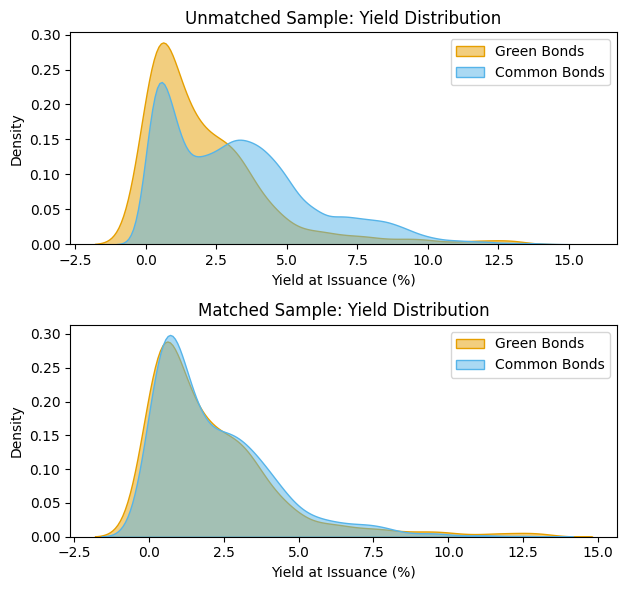

In [64]:
# Define accessible colors
color_green_bond = "#E69F00"  # Orange (Color Universal Design)
color_common_bond = "#56B4E9"  # Blue (Color Universal Design)

# Set up figure
plt.figure(figsize=(12, 6))

# Subplot 1: Unmatched Sample - Green Bonds vs. Common Bonds
plt.subplot(2, 2, 1)
sns.kdeplot(data=dt[dt['greenid'] == 1], x='yield_issue', fill=True, label="Green Bonds", color=color_green_bond, alpha=0.5)
sns.kdeplot(data=dt[dt['greenid'] == 0], x='yield_issue', fill=True, label="Common Bonds", color=color_common_bond, alpha=0.5)
plt.xlabel('Yield at Issuance (%)')
plt.title('Unmatched Sample: Yield Distribution')
plt.legend()

# Subplot 2: Matched Sample - Green Bonds vs. Common Bonds
plt.subplot(2, 2, 3)
sns.kdeplot(data=matched_df[matched_df['greenid'] == 1], x='yield_issue', fill=True, label="Green Bonds", color=color_green_bond, alpha=0.5)
sns.kdeplot(data=matched_df[matched_df['greenid'] == 0], x='yield_issue', fill=True, label="Common Bonds", color=color_common_bond, alpha=0.5)
plt.xlabel('Yield at Issuance (%)')
plt.title('Matched Sample: Yield Distribution')
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


**Key Takeaways:**

- The lack of significant differences confirms that matching was successful, meaning the two groups are balanced.
- There is **no strong evidence** that green bonds have significantly different yields or financial characteristics compared to common bonds.